In [29]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from scipy.interpolate import make_interp_spline, BSpline

In [10]:
terns = pd.read_csv("arctic_tern_migration.csv")
# Using dayfirst instead of format as times are in different formats
terns["Date_Time"] = pd.to_datetime(terns["Date"] + " " + terns["Time"], dayfirst = True)
terns = terns.dropna(subset = ["Lat", "Long"])
# get the month
terns["Month"] = pd.DatetimeIndex(terns["Date_Time"]).month
terns = terns.reindex(range(0, len(terns)))
terns

,Study,Bird ID,Tag Type,Date,Time,Lat,Long,Height,Date_Time,Month
0,Hawkes,16806,GPS,21/06/2018,11:00:22,64.01665,-22.77402,104.75,2018-06-21 11:00:22,6.0
1,Hawkes,16806,GPS,22/06/2018,05:00:22,63.83494,-23.21845,87.50,2018-06-22 05:00:22,6.0
2,Hawkes,16806,GPS,22/06/2018,23:00:21,64.04323,-22.78708,74.75,2018-06-22 23:00:21,6.0
3,Hawkes,16806,GPS,23/06/2018,17:00:21,64.01581,-22.70757,76.50,2018-06-23 17:00:21,6.0
4,Hawkes,16806,GPS,24/06/2018,11:00:19,63.70851,-23.26070,92.00,2018-06-24 11:00:19,6.0
...,...,...,...,...,...,...,...,...,...,...
6054,Alerstam,G (Y2),Geolocator,20/07/2014,19:56:21,46.12780,-27.39415,NaN,2014-07-20 19:56:21,7.0
6055,Alerstam,G (Y2),Geolocator,21/07/2014,19:53:36,43.46848,-26.75714,NaN,2014-07-21 19:53:36,7.0
6056,Alerstam,G (Y2),Geolocator,22/07/2014,19:55:21,42.38501,-27.12248,NaN,2014-07-22 19:55:21,7.0
6057,Alerstam,G (Y2),Geolocator,23/07/2014,19:57:51,41.11195,-27.74023,NaN,2014-07-23 19:57:51,7.0


In [11]:
x = []

# trying to remove erroneous results
for i in range(1, len(terns)):
    diff_lat = abs(terns.iloc[i]["Lat"] - terns.iloc[i-1]["Lat"])
    diff_long = abs(terns.iloc[i]["Long"] - terns.iloc[i-1]["Long"])
    if ((terns.iloc[i]["Bird ID"] == terns.iloc[i-1]["Bird ID"]) & 
        ((diff_lat > 20) | (diff_long > 20))):
        x.append(i)

for i in range(1, len(x)):
    if (x[i] - x[i-1] == 1):
        terns = terns.drop(index = x[i-1])
        
terns = terns.reindex(range(0, len(terns)))
terns

,Study,Bird ID,Tag Type,Date,Time,Lat,Long,Height,Date_Time,Month
0,Hawkes,16806,GPS,21/06/2018,11:00:22,64.01665,-22.77402,104.75,2018-06-21 11:00:22,6.0
1,Hawkes,16806,GPS,22/06/2018,05:00:22,63.83494,-23.21845,87.50,2018-06-22 05:00:22,6.0
2,Hawkes,16806,GPS,22/06/2018,23:00:21,64.04323,-22.78708,74.75,2018-06-22 23:00:21,6.0
3,Hawkes,16806,GPS,23/06/2018,17:00:21,64.01581,-22.70757,76.50,2018-06-23 17:00:21,6.0
4,Hawkes,16806,GPS,24/06/2018,11:00:19,63.70851,-23.26070,92.00,2018-06-24 11:00:19,6.0
...,...,...,...,...,...,...,...,...,...,...
6046,Alerstam,G (Y2),Geolocator,12/07/2014,17:56:10,57.30560,2.42614,NaN,2014-07-12 17:56:10,7.0
6047,Alerstam,G (Y2),Geolocator,13/07/2014,18:43:23,58.50884,-9.29318,NaN,2014-07-13 18:43:23,7.0
6048,Alerstam,G (Y2),Geolocator,14/07/2014,19:09:38,59.34525,-15.76504,NaN,2014-07-14 19:09:38,7.0
6049,Alerstam,G (Y2),Geolocator,15/07/2014,19:29:39,57.76255,-20.86415,NaN,2014-07-15 19:29:39,7.0


In [12]:
lats = [min(terns["Lat"]), max(terns["Lat"])]
print(lats)
longs = [min(terns["Long"]), max(terns["Long"])]
print(longs)

# make sure longitude is in correct range
if (longs[0] < -180):
    terns["Long"] = terns["Long"].replace([min(terns["Long"])], 360 + min(terns["Long"]))
    longs = [min(terns["Long"]), max(terns["Long"])]
print(longs)

[-76.84, 71.6]
[-181.658, 178.7207]
[-179.20142, 178.7207]


In [13]:
grouped = terns.groupby(["Study", "Bird ID"])
grouped.describe()

Lat                                             \
                   count       mean        std       min        25%   
Study    Bird ID                                                      
Alerstam A (Y1)    287.0  -6.559477  53.385631 -68.51000 -60.440000   
         A (Y2)    147.0   1.569728  43.442578 -62.71000 -39.720000   
         B         147.0   0.554392  48.160298 -63.80682 -43.145770   
         C         141.0   4.823692  47.610689 -61.94099 -39.632940   
         D         257.0  -7.875749  52.534893 -70.45500 -59.389500   
         E (Y1)    160.0  -3.757258  55.592666 -71.07800 -63.010430   
         E (Y2)    108.0 -44.886448  30.643021 -63.52599 -61.405840   
         F         240.0 -15.747471  51.264913 -66.93614 -61.693750   
         G (Y1)    292.0  -7.735393  51.793593 -69.03475 -58.439625   
         G (Y2)     27.0  55.472904   1.962692  50.80586  54.522530   
Egevang  ARTE_370  397.0 -20.322116  49.503025 -76.84000 -63.790000   
         ARTE_371  478.0 -25.097782  46.125931 -71.21000 -63.322500   
         ARTE_373  383.0 -26.378016  43.259552 -76.62000 -65.780000   
         ARTE_376  426.0 -17.585094  45.177501 -70.19000 -60.360000   
         ARTE_390  410.0 -26.429610  44.807918 -68.89000 -64.430000   
         ARTE_395  172.0   2.313256  37.612111 -62.61000 -32.307500   
         ARTE_406  422.0 -21.922014  44.274020 -73.38000 -62.677500   
         ARTE_408  410.0 -21.687683  45.774182 -72.21000 -62.760000   
         ARTE_410  369.0 -21.682358  45.016390 -71.31000 -62.830000   
Hawkes   16806     124.0  21.782203  40.236518 -37.06706 -15.853130   
         21829     201.0   0.907292  47.448491 -65.06066 -38.555570   

                                                    Long             ...  \
                         50%        75%       max  count       mean  ...   
Study    Bird ID                                                     ...   
Alerstam A (Y1)   -16.290000  54.815000  57.08000  287.0  39.504251  ...   
         A (Y2)   -14.140000  54.325000  58.43000  147.0  43.931837  ...   
         B         -7.544190  54.639740  56.13267  147.0  63.512209  ...   
         C          6.574710  54.679290  56.78672  141.0  32.156714  ...   
         D        -32.074870  52.043270  56.60505  257.0  17.759419  ...   
         E (Y1)     4.460860  55.155028  61.07889  160.0  29.730592  ...   
         E (Y2)   -60.113355 -40.202875  55.50460  108.0  26.541335  ...   
         F        -37.714160  53.166443  63.40150  240.0  48.355804  ...   
         G (Y1)   -24.998415  53.542055  57.88146  292.0  53.774907  ...   
         G (Y2)    55.713710  56.640110  59.34525   27.0   8.770606  ...   
Egevang  ARTE_370 -46.940000  43.220000  68.14000  397.0 -28.824106  ...   
         ARTE_371 -42.035000   4.307500  70.12000  478.0 -16.319791  ...   
         ARTE_373 -37.220000   0.640000  70.98000  383.0  -8.792115  ...   
         ARTE_376 -33.045000  30.447500  70.23000  426.0 -12.068286  ...   
         ARTE_390 -40.655000   5.510000  71.60000  410.0 -29.993927  ...   
         ARTE_395 -10.485000  42.092500  69.87000  172.0 -16.708140  ...   
         ARTE_406 -37.850000  15.025000  70.00000  422.0 -25.771137  ...   
         ARTE_408 -39.115000  36.420000  65.67000  410.0 -15.959951  ...   
         ARTE_410 -39.230000  26.780000  68.02000  369.0 -34.247073  ...   
Hawkes   16806     40.701475  63.736792  65.07496  124.0 -13.370712  ...   
         21829    -21.222060  59.042390  64.22285  201.0  32.786769  ...   

                  Height          Month                                      \
                     75%     max  count      mean       std  min  25%   50%   
Study    Bird ID                                                              
Alerstam A (Y1)      NaN     NaN  287.0  6.592334  3.453641  1.0  4.0   6.0   
         A (Y2)      NaN     NaN  147.0  8.278912  1.812371  6.0  7.0   8.0   
         B           NaN     NaN  147.0  8.408163  1.893591  6.0  7.0   8.0   
         C       

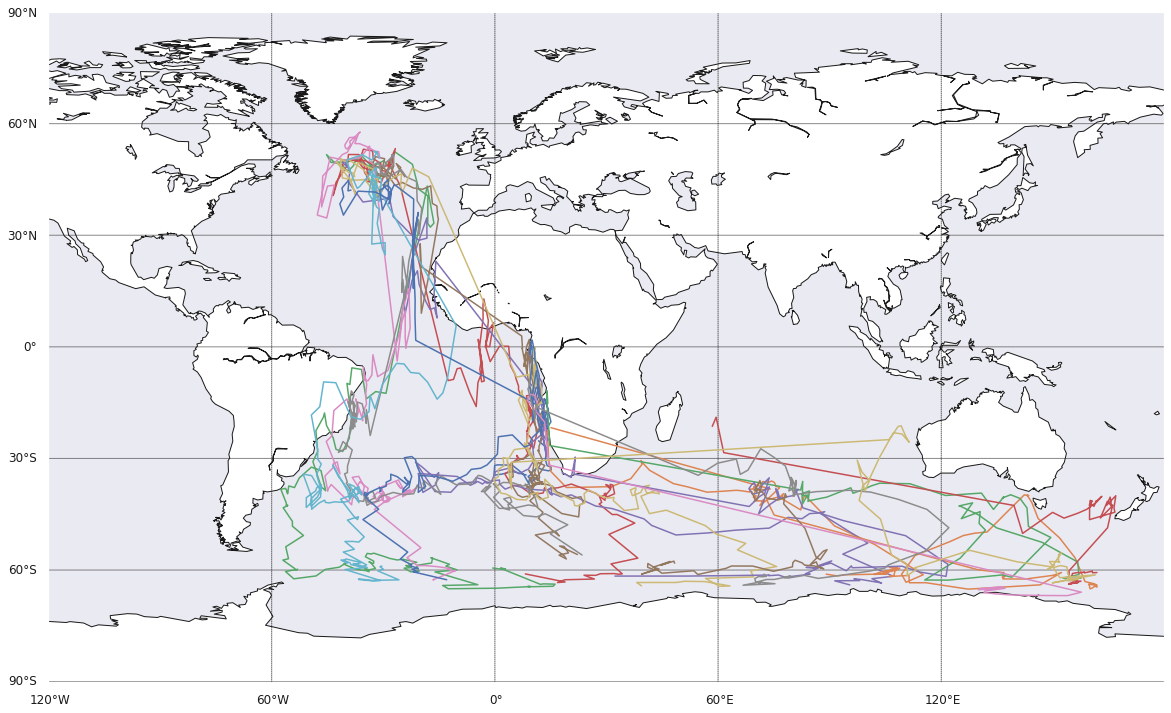

In [44]:
fig = plt.figure(figsize = [20, 25])  # a new figure window
ax = fig.add_subplot(1, 1, 1)
map = Basemap(projection = 'cyl', llcrnrlat = -90, urcrnrlat = 90, 
             llcrnrlon = -120, urcrnrlon = 180, resolution = 'c', ax = ax)
map.drawcoastlines()
map.fillcontinents(color = "white")
map.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
map.drawmeridians(np.arange(-120.,180.,60.),labels=[0,0,0,1])

# drop bird with weird observations
terns_plt = terns.drop(terns[terns["Bird ID"] == "E (Y2)"].index)

# autumn migration
terns_autumn = terns_plt[(terns_plt["Month"] > 8) & (terns_plt["Month"] < 12)]

for bird in terns_autumn["Bird ID"].unique():
    df = terns_autumn[terns_autumn["Bird ID"] == bird]
    map.plot(df["Long"], df["Lat"], ax = ax)

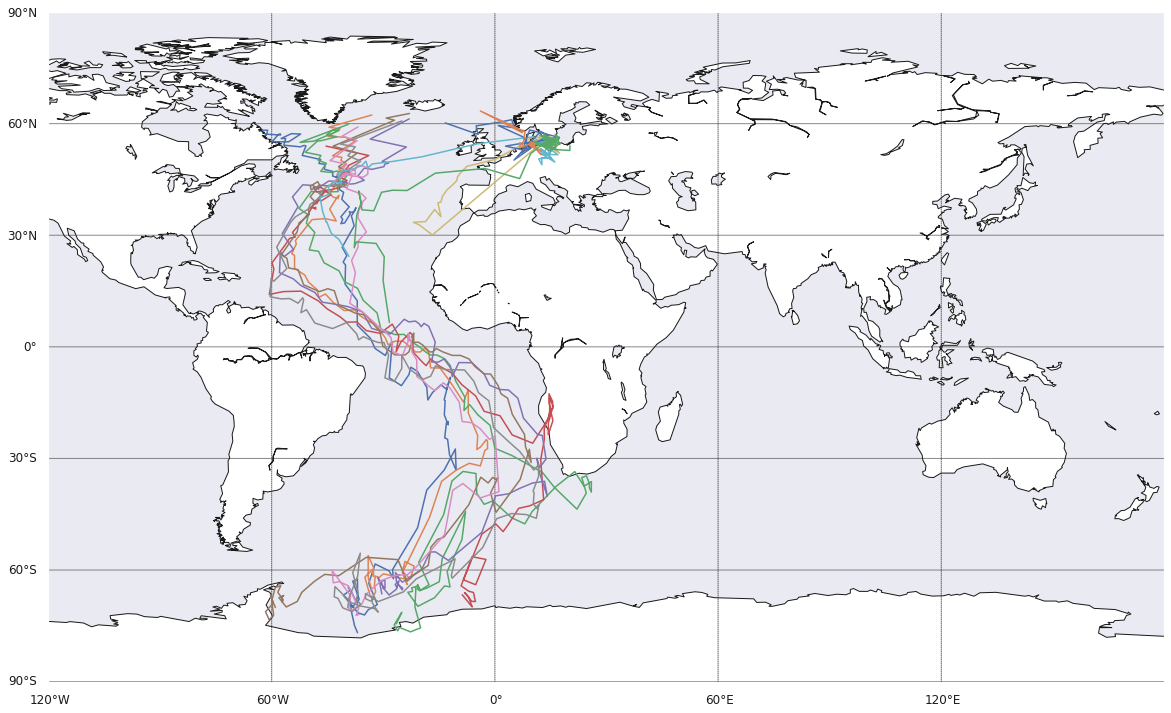

In [45]:
fig = plt.figure(figsize = [20, 25])
ax = fig.add_subplot(1, 1, 1)
map = Basemap(projection = 'cyl', llcrnrlat = -90, urcrnrlat = 90, 
             llcrnrlon = -120, urcrnrlon = 180, resolution = 'c', ax = ax)
map.drawcoastlines()
map.fillcontinents(color = "white")
map.drawparallels(np.arange(-90., 120., 30.),labels=[1, 0, 0, 0])
map.drawmeridians(np.arange(-120., 180., 60.),labels=[0, 0, 0, 1])

# spring migration
terns_spring = terns_plt[(terns_plt["Month"] > 3) & (terns_plt["Month"] < 6)]

# something feels wrong about this plot?
for bird in terns_spring["Bird ID"].unique():
    df = terns_spring[terns_spring["Bird ID"] == bird]
    map.plot(df["Long"], df["Lat"], ax = ax)

In [40]:
# previously months <5 weren't converted correctly
terns[terns["Month"] == 1]
# seems to be solved now

,Study,Bird ID,Tag Type,Date,Time,Lat,Long,Height,Date_Time,Month
523,Egevang,ARTE_370,Geolocator,30/01/2008,01:23,-66.72000,-17.47000,NaN,2008-01-30 01:23:00,1.0
524,Egevang,ARTE_370,Geolocator,30/01/2008,12:54,-66.80000,-10.20000,NaN,2008-01-30 12:54:00,1.0
525,Egevang,ARTE_370,Geolocator,31/01/2008,01:02,-65.79000,-12.17000,NaN,2008-01-31 01:02:00,1.0
526,Egevang,ARTE_370,Geolocator,31/01/2008,12:58,-65.85000,-11.16000,NaN,2008-01-31 12:58:00,1.0
969,Egevang,ARTE_371,Geolocator,01/01/2008,01:11,-61.14000,-16.97000,NaN,2008-01-01 01:11:00,1.0
...,...,...,...,...,...,...,...,...,...,...
5880,Alerstam,G (Y1),Geolocator,27/01/2014,12:08:06,-59.09800,91.16300,NaN,2014-01-27 12:08:06,1.0
5881,Alerstam,G (Y1),Geolocator,28/01/2014,12:03:21,-57.78300,92.39950,NaN,2014-01-28 12:03:21,1.0
5882,Alerstam,G (Y1),Geolocator,29/01/2014,12:05:13,-64.31013,92.16054,NaN,2014-01-29 12:05:13,1.0
5883,Alerstam,G (Y1),Geolocator,30/01/2014,12:00:15,-64.28202,93.32695,NaN,2014-01-30 12:00:15,1.0
